In [1]:
# image processing
from PIL import Image
from io import BytesIO

# data analysis
import math
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
from importlib import reload
from mpl_toolkits import mplot3d
import seaborn as sns

# modeling
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
import logging
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

# Image Detail

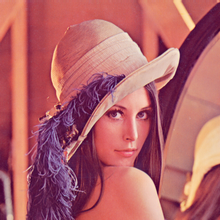

In [3]:
ori_img = Image.open("images/lena.png")
ori_img

In [4]:
X = np.array(ori_img.getdata())
ori_pixels = X.reshape(*ori_img.size, -1)
ori_pixels.shape

(220, 220, 3)

220 x 220 pixels with 3 channel RGB

In [5]:
ori_img_n_colors = len(set(ori_img.getdata()))
ori_img_n_colors

37270

Original image has 37270 unique colors.

In [6]:
def imageByteSize(img):
    img_file = BytesIO()
    image = Image.fromarray(np.uint8(img))
    image.save(img_file, 'png')
    return img_file.tell()/1024

ori_img_size = imageByteSize(ori_img)
ori_img_size

85.99609375

Original image size: 86KB

# 3D Visualization
We can visualize each pixels in 3D plot based on the their RGB values. Here are the first 220 pixels, which represent the first row pixels in the image.

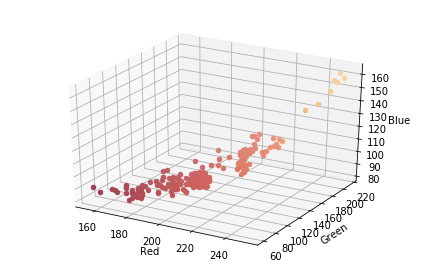

In [7]:
reload(plt)
fig = plt.figure("3-D Plot of Image")
ax = plt.axes(projection='3d')
for px in X[:220]:
    ax.scatter3D(*px, c = np.array([px])/255)
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
ax.dist = 11
plt.tight_layout()
plt.show()

# Kmeans Clustering

## Idea

In [8]:
kmeans = KMeans(n_clusters = 2,
                n_jobs = -1,
                random_state = 123).fit(X)
pd.DataFrame(kmeans.cluster_centers_, columns = ['Red', 'Green', 'Blue'])

Red       Green        Blue
0  130.542889   47.388621   77.450236
1  213.718313  133.891310  124.260309

Replace each pixels value in a cluster with its centroid value

In [9]:
def replaceWithCentroid(kmeans):
    new_pixels = []
    for label in kmeans.labels_:
        pixel_as_centroid = list(kmeans.cluster_centers_[label])
        new_pixels.append(pixel_as_centroid)
    new_pixels = np.array(new_pixels).reshape(*ori_img.size, -1)
    return new_pixels
new_pixels = replaceWithCentroid(kmeans)
new_pixels

array([[[213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        ...,
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857]],

       [[213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        ...,
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857]],

       [[213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        ...,
        [213.71831327, 133.89131036, 124.26030857],
        [213.71831327, 133.89131036, 124.26030857],
        [130.54288939,  47.38862097,  77.45023599]],

       ...,

      

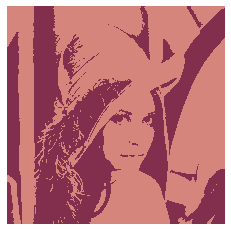

In [10]:
def plotImage(img_array, size):
    reload(plt)
    plt.imshow(np.array(img_array/255).reshape(*size))
    plt.axis('off')
    return plt
    
plotImage(new_pixels, new_pixels.shape).show()

In [11]:
imageByteSize(new_pixels)

4.3837890625

In [12]:
ori_img_total_variance = sum(np.linalg.norm(X - np.mean(X, axis = 0), axis = 1)**2)
ori_img_total_variance

302426700.6427498

## Iterate

In [13]:
range_k_clusters = (2, 21)

kmeans_result = []
for k in range(*range_k_clusters):
    # CLUSTERING
    kmeans = KMeans(n_clusters = k,
                    n_jobs = -1,
                    random_state = 123).fit(X)
    
    # REPLACE PIXELS WITH ITS CENTROID
    new_pixels = replaceWithCentroid(kmeans)
    
    # CALCULATE BETWEEN CLUSTER SUM OF SQUARE (BCSS)
    _, label_counts = np.unique(kmeans.labels_, return_counts = True)
    diff_cluster_sq = np.linalg.norm(kmeans.cluster_centers_ - np.mean(X, axis = 0), axis = 1)**2
    BCSS = sum(label_counts * diff_cluster_sq)
    
    metric = {
        "No. of Colors": k,
        "Centroids": kmeans.cluster_centers_,
        "Pixels": new_pixels,
        "WCSS": kmeans.inertia_,
        "BCSS": BCSS,
        "Relative Variance": 100*(kmeans.inertia_ + BCSS)/ori_img_total_variance,
        "Image Size (KB)": imageByteSize(new_pixels)
    }
    
    kmeans_result.append(metric)
kmeans_result = pd.DataFrame(kmeans_result).set_index("No. of Colors")
kmeans_result

Centroids  \
No. of Colors                                                      
2              [[130.5428893905358, 47.38862097270393, 77.450...   
3              [[110.75055053536703, 35.51924975320544, 72.95...   
4              [[101.76369371954503, 29.535799636743178, 69.8...   
5              [[230.3257831325257, 189.56481927710567, 166.2...   
6              [[143.7538265306115, 89.03869047619096, 129.61...   
7              [[130.62918918918527, 50.59870270270022, 83.24...   
8              [[94.12757850480178, 23.71501773748244, 65.466...   
9              [[226.33964646464273, 156.76578282828027, 134....   
10             [[234.86894215737001, 199.23293381969506, 173....   
11             [[220.88402061855456, 169.5544458762862, 152.4...   
12             [[121.38719999999812, 59.00853333333183, 105.3...   
13             [[221.820959264124, 170.97010512483328, 152.92...   
14             [[151.6036717062639, 108.58639308855295, 151.1...   
15             [[220.97282816685413, 116.01990049751042, 106....   
16             [[222.2772320454013, 120.16437459069864, 108.0...   
17             [[104.63834092058222, 31.283004552349496, 69.8...   
18             [[222.2723025583946, 119.95973303670542, 107.9...   
19             [[87.39933759166777, 18.797728885731942, 62.42...   
20             [[86.71128404668791, 18.201556420230872, 62.02...   

                                                          Pixels  \
No. of Colors                                                      
2              [[[213.71831326970442, 133.89131036391043, 124...   
3              [[[225.44421388667087, 167.00351157222383, 147...   
4              [[[212.22476813966176, 122.26475722858449, 114...   
5              [[[214.57149746804404, 134.9070010449294, 123....   
6              [[[216.79463980880337, 136.00623079549067, 122...   
7              [[[217.59388368070853, 137.3576954582662, 122....   
8              [[[213.39740529319698, 128.35910742085883, 117...   
9              [[[226.33964646464273, 156.76578282828027, 134...   
10             [[[227.54112013324607, 143.86445971267722, 121...   
11             [[[229.63865954346397, 145.22219524040568, 121...   
12             [[[232.0675287356287, 146.05028735631967, 119....   
13             [[[232.373039806993, 146.9517490952934, 120.35...   
14             [[[232.1878698224818, 146.8443786982227, 120.5...   
15             [[[232.26439169139124, 146.74065281898896, 120...   
16             [[[232.79283130548842, 148.43834265044183, 121...   
17             [[[233.0403556771515, 149.07865937072293, 121....   
18             [[[233.0540075679364, 147.91916064671275, 120....   
19             [[[225.982119635888, 129.52698309492663, 111.6...   
20             [[[226.09115014915207, 129.74444812727694, 111...   

                       WCSS          BCSS  Relative Variance  Image Size (KB)  
No. of Colors                                                                  
2              1.092607e+08  1.930717e+08          99.968813         4.383789  
3              6.079592e+07  2.416344e+08         100.001211         6.662109  
4              3.829205e+07  2.645456e+08         100.135872         8.654297  
5              2.953883e+07  2.729107e+08         100.007562        10.584961  
6              2.440947e+07  2.780032e+08          99.995357        11.326172  
7              2.088744e+07  2.813609e+08          99.941020        13.569336  
8              1.829728e+07  2.843931e+08         100.087178        15.281250  
9              1.623060e+07  2.864122e+08         100.071443        16.035156  
10             1.467699e+07  2.875256e+08          99.925908        17.332031  
11             1.337110e+07  2.890826e+08         100.008927        17.481445  
12             1.234860e+07  2.899873e+08          99.969966        18.048828  
13             1.131855e+07  2.913483e+08         100.079404        20.426758  
14             1.040832e+07  2.920891e+08         100.023381        20.708984

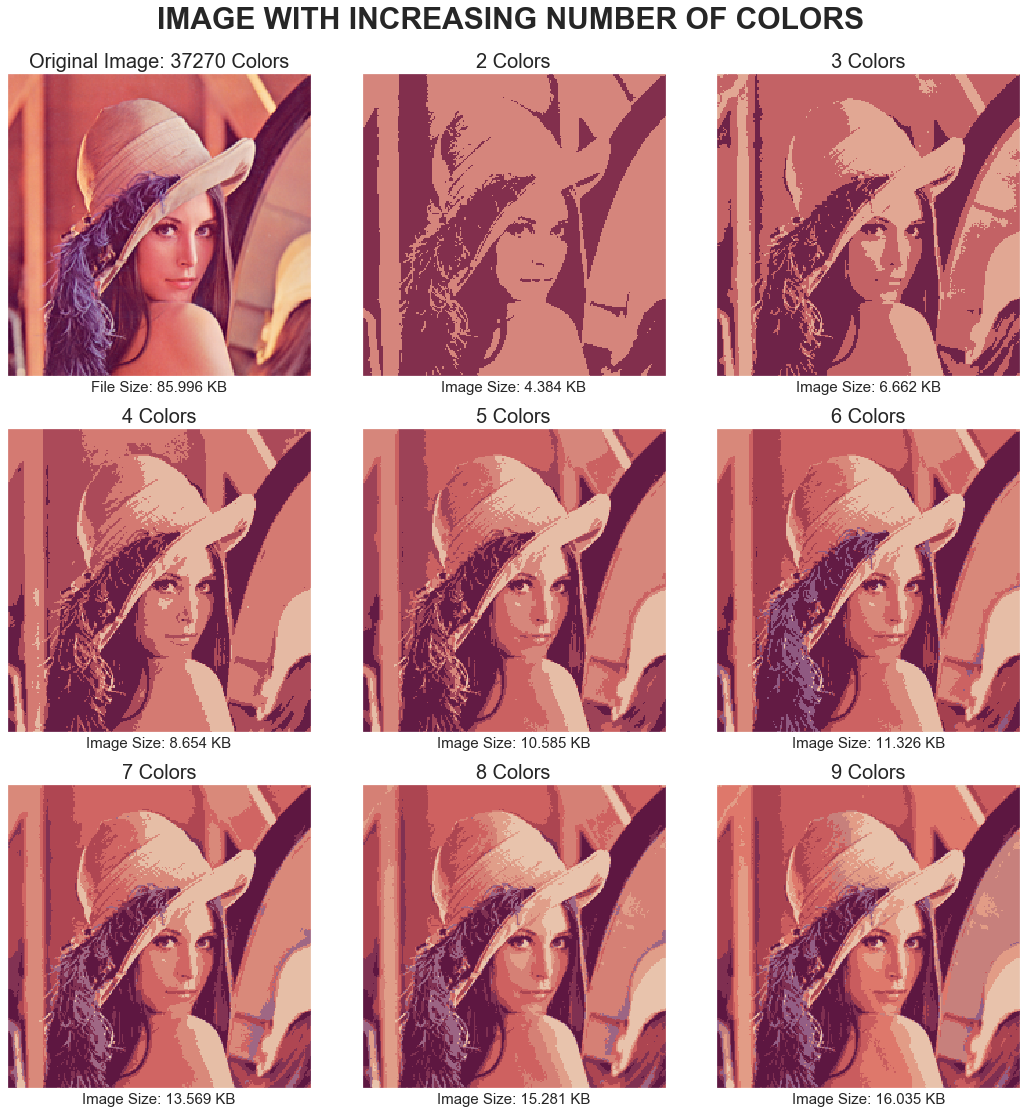

In [14]:
sns.set()
fig, axes = plt.subplots(3, 3, figsize=(15,15))

# PLOT ORIGINAL IMAGE
axes[0][0].imshow(X.reshape(*ori_img.size, 3))
axes[0][0].set_title("Original Image: {} Colors".format(ori_img_n_colors), fontsize = 20)
axes[0][0].set_xlabel("File Size: {:.3f} KB".format(ori_img_size), fontsize = 15)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])

# PLOT COLOR-REDUCED IMAGE
for ax, k, pixels in zip(axes.flat[1:], kmeans_result.index, kmeans_result["Pixels"]):
    compressed_image = np.array(pixels/255).reshape(*ori_img.size, 3)
    ax.imshow(compressed_image)
    ax.set_title("{} Colors".format(k), fontsize=20)
    ax.set_xlabel("Image Size: {:.3f} KB".format(kmeans_result.loc[k, "Image Size (KB)"]), fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.suptitle("IMAGE WITH INCREASING NUMBER OF COLORS", size = 30, y = 1.03, fontweight = "bold")
plt.show()

## Metric: Search for Optimal K
- Within Cluster Sum of Square (WCSS)
- Between Cluster Sum of Square (BCSS)
- Relative Variance = Total Variance of Compressed Images (Sum of WCSS and BCSS) divided by Total Variance of Original Image (BCSS)
- Image Size in KB

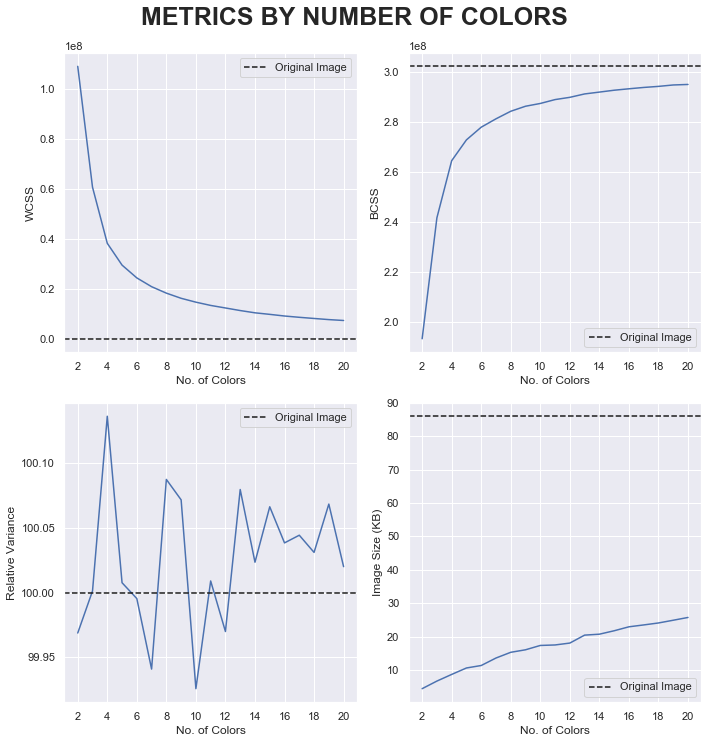

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for ax, metric in zip(axes.flat, kmeans_result.columns[2:]):
    sns.lineplot(x = kmeans_result.index, y = metric, data = kmeans_result, ax = ax)
    
    if metric == "WCSS":
        y_val = 0
    elif metric == "BCSS":
        y_val = ori_img_total_variance
    elif metric == "Relative Variance":
        y_val = 100
    elif metric == "Image Size (KB)":
        y_val = ori_img_size
    
    ax.axhline(y = y_val, color = 'k', linestyle = '--', label = "Original Image")
    ax.set_xticks(kmeans_result.index[::2])
    ax.ticklabel_format(useOffset = False)
    ax.legend()
plt.tight_layout()
fig.suptitle("METRICS BY NUMBER OF COLORS", size = 25, y = 1.03, fontweight = "bold")
plt.show()

How to locate optimal number of colors $k$? Here is the idea:
1. Connect the first and last points with a straight line
2. Calculate each perpendicular distance from each point to that line
3. Consider the longest distance as the elbow

Illustration ([Reference](https://www.researchgate.net/publication/281443471_Novel_Clustering_Selection_Criterion_for_Fast_Binary_Key_Speaker_Diarization)):
<img src="images/elbow_method.png" width="400">

Next question, how to calculate the perpendicular distance? Simple, we use the distance formula from point $(x_0,y_0)$ to line $ax+by+c=0$ as illustrated below ([Reference](https://www.youtube.com/watch?v=tngPrM2d-OM)):
<img src="images/distance_formula.jpg" width="400">

In [16]:
def locateOptimalElbow(x, y):
    # START AND FINAL POINTS
    p1 = (x[0], y[0])
    p2 = (x[-1], y[-1])
    
    # EQUATION OF LINE: GRADIENT AND CONSTANT
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    c = (p2[1] - (m * p2[0]))
    
    # DISTANCE FROM EACH POINTS TO LINE
    a, b = m, -1
    dist = np.array([abs(a*x0+b*y0+c)/math.sqrt(a**2+b**2) for x0, y0 in zip(x,y)])
    return np.argmax(dist) + x[0]

But, how if the graph is not an increasing or decreasing curve function? We can use finite difference method to locate the most drastic change in gradient using second derivative.

What is finite difference method? It is a numerical methods to approximate the derivative of a discrete values. There are three types which are commonly considered:
1. Forward Difference: $f'(x) = \dfrac{f(x+h)-f(x)}{h} + O(h)$
2. Backward Difference: $f'(x) = \dfrac{f(x)-f(x-h)}{h} + O(h)$
3. Central Difference: $f'(x) = \dfrac{f(x+h)-f(x-h)}{2h} + O(h^2)$

where:
* $f'(x)$ is the first derivative of function $f(x)$
* $h$ is the step, in this case $h=1$ (the step in the number of colors)
* $O(h)$ is the first degree error term
* $O(h^2)$ is the second degree error term

Central difference is expected to give better results than the other two, since it has higher degree error term. We use forward difference only for the first point and backward difference only for the last point.

In [17]:
def calculateDerivative(data):
    derivative = []
    for i in range(len(data)):
        if i == 0:
            # FORWARD DIFFERENCE
            d = data[i+1] - data[i]
        elif i == len(data) - 1:
            # BACKWARD DIFFERENCE
            d = data[i] - data[i-1]
        else:
            # CENTER DIFFERENCE
            d = (data[i+1] - data[i-1])/2
        derivative.append(d)
    return np.array(derivative)

def locateDrasticChange(x, y):
    # CALCULATE GRADIENT BY FIRST DERIVATIVE
    first_derivative = calculateDerivative(np.array(y))
    
    # CALCULATE CHANGE OF GRADIENT BY SECOND DERIVATIVE
    second_derivative = calculateDerivative(first_derivative)

    return np.argmax(np.abs(second_derivative)) + x[0]

In [18]:
k_opt_by_WCSS = locateOptimalElbow(kmeans_result.index, kmeans_result["WCSS"].values)
k_opt_by_WCSS

5

In [19]:
k_opt_by_BCSS = locateOptimalElbow(kmeans_result.index, kmeans_result["BCSS"].values)
k_opt_by_BCSS

5

In [20]:
k_opt_by_var = locateDrasticChange(kmeans_result.index, kmeans_result["Relative Variance"].values)
k_opt_by_var

4

In [21]:
k_opt_by_size = locateDrasticChange(kmeans_result.index, kmeans_result["Image Size (KB)"].values)
k_opt_by_size

12

In [22]:
k_opt = max(k_opt_by_WCSS, k_opt_by_BCSS, k_opt_by_var, k_opt_by_size)
k_opt

12

## Compare to Original Image

In [23]:
ori = {
    "Type": "Original",
    "Pixels": X,
    "No. of Colors": ori_img_n_colors,
    "Image Size (KB)": ori_img_size,
    "Relative Variance": 100
}
color_reduced = {
    "Type": "Color-Reduced",
    "Pixels": kmeans_result.loc[k_opt, "Pixels"],
    "No. of Colors": k_opt,
    "Image Size (KB)": kmeans_result.loc[k_opt, "Image Size (KB)"],
    "Relative Variance": kmeans_result.loc[k_opt, "Relative Variance"]
}
ori_vs_kmeans = pd.DataFrame([ori, color_reduced]).set_index("Type")
ori_vs_kmeans

Pixels  \
Type                                                               
Original       [[225, 137, 127], [224, 137, 127], [227, 134, ...   
Color-Reduced  [[[232.0675287356287, 146.05028735631967, 119....   

               No. of Colors  Image Size (KB)  Relative Variance  
Type                                                              
Original               37270        85.996094         100.000000  
Color-Reduced             12        18.048828          99.969966

In [24]:
relative_size = ori_vs_kmeans.loc["Color-Reduced", "Image Size (KB)"]/ori_vs_kmeans.loc["Original", "Image Size (KB)"]
print("Size: {:.3f}% of original image size".format(relative_size * 100))

Size: 20.988% of original image size


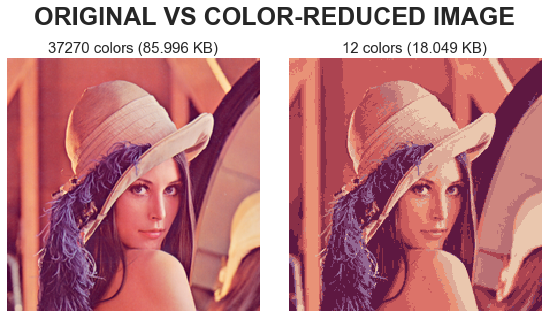

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
for ax, (typ, row) in zip(axes.flat, ori_vs_kmeans.iterrows()):
    img_array = np.array(row["Pixels"]/255)
    ax.imshow(img_array.reshape(*ori_img.size, 3))
    ax.axis("off")
    ax.set_title("{} colors ({:.3f} KB)".format(row["No. of Colors"], row["Image Size (KB)"]), fontsize=15)
plt.tight_layout()
fig.suptitle("ORIGINAL VS COLOR-REDUCED IMAGE", size = 25, y = 1.1, fontweight = "bold")
plt.show()

# Pricinpal Component Analysis

## Principal Components of RGB

In [26]:
res = []
cum_var = []
X_t = np.transpose(X)
for channel in range(3):
    # SEPARATE EACH RGB CHANNEL
    pixel = X_t[channel].reshape(*ori_pixels.shape[:2])
    
    # PCA
    pca = PCA(random_state = 123)
    pixel_pca = pca.fit_transform(pixel)
    
    pca_dict = {
        "Pixels": pixel_pca,
        "Components": pca.components_,
        "Mean": pca.mean_
    }
    res.append(pca_dict)
    
    # EVALUATION
    cum_var.append(np.cumsum(pca.explained_variance_ratio_))

Visualizing Principal Components

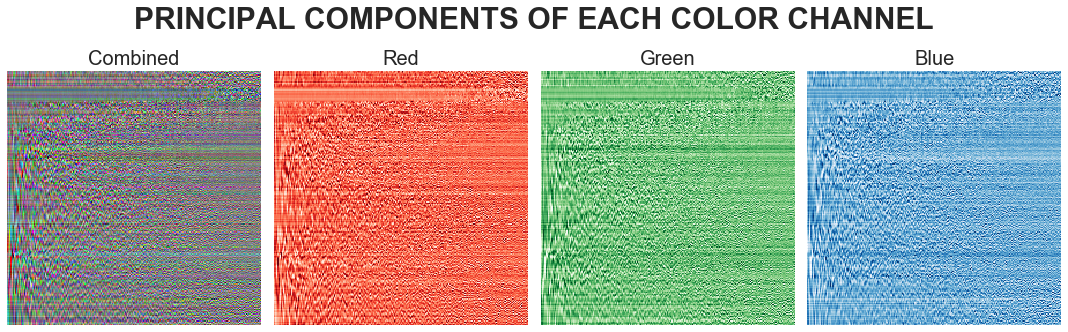

In [27]:
scaler = MinMaxScaler()
scaled_pixels = [scaler.fit_transform(res[i]["Components"])*255 for i in range(3)]

fig, axes = plt.subplots(1, 4, figsize=(15,5))
cmap_list = ["Reds", "Greens", "Blues"]

axes[0].imshow(np.array(scaled_pixels).T/255)
axes[0].axis("off")
axes[0].set_title("Combined", size = 20)

for idx, ax, px in zip(range(3), axes[1:], scaled_pixels):
    ax.imshow((px/255).T, cmap = cmap_list[idx])
    ax.axis("off")
    ax.set_title(cmap_list[idx][:-1], size = 20)
plt.tight_layout()

fig.suptitle("PRINCIPAL COMPONENTS OF EACH COLOR CHANNEL", size = 30, y = 1.03, fontweight = "bold")
plt.show()

## Cumulative Explained Variance

In [28]:
cum_var_df = pd.DataFrame(np.array(cum_var).T * 100, 
                          index = range(1, pca.n_components_+1),
                          columns = ["Explained Variance by Red",
                                     "Explained Variance by Green",
                                     "Explained Variance by Blue"])
cum_var_df["Explained Variance"] = cum_var_df.mean(axis = 1)
cum_var_df

Explained Variance by Red  Explained Variance by Green  \
1                    30.322449                    24.873504   
2                    46.154303                    41.736299   
3                    56.733958                    52.312534   
4                    64.023442                    60.106712   
5                    70.909755                    65.396127   
..                         ...                          ...   
216                  99.999999                    99.999999   
217                  99.999999                   100.000000   
218                 100.000000                   100.000000   
219                 100.000000                   100.000000   
220                 100.000000                   100.000000   

     Explained Variance by Blue  Explained Variance  
1                     20.647425           25.281126  
2                     40.449145           42.779916  
3                     50.879293           53.308595  
4                     58.212843           60.780999  
5                     63.926641           66.744174  
..                          ...                 ...  
216                   99.999997           99.999998  
217                   99.999999           99.999999  
218                  100.000000          100.000000  
219                  100.000000          100.000000  
220                  100.000000          100.000000  

[220 rows x 4 columns]

## Iterate

In [29]:
pca_results = []
for n in range(1, pca.n_components_+1):
    # SELECT N-COMPONENTS FROM PC
    temp_res = []
    for channel in range(3):
        pca_channel = res[channel]
        pca_pixel = pca_channel["Pixels"][:, :n]
        pca_comp = pca_channel["Components"][:n, :]
        pca_mean = pca_channel["Mean"]
        compressed_pixel = np.dot(pca_pixel, pca_comp) + pca_mean
        temp_res.append(compressed_pixel.T)
    compressed_image = np.transpose(temp_res)
    
    pca_dict = {
        "n": n,
        "Pixels": compressed_image,
        "Explained Variance": cum_var_df["Explained Variance"][n],
        "Image Size (KB)": imageByteSize(compressed_image),
        "No. of Colors": len(np.unique(np.uint8(compressed_image).reshape(-1, 3), axis = 0))
    }
    
    pca_results.append(pca_dict)

pca_results = pd.DataFrame(pca_results).set_index("n")
pca_results.head()

Pixels  Explained Variance  \
n                                                                          
1  [[[197.04434252288146, 74.80874312804772, 81.2...           25.281126   
2  [[[202.69693083491518, 75.77550819768376, 80.3...           42.779916   
3  [[[199.9502620731646, 85.94707173824675, 87.64...           53.308595   
4  [[[199.09774664541806, 83.85824159985995, 87.0...           60.780999   
5  [[[208.1853515202986, 91.19498360910256, 87.31...           66.744174   

   Image Size (KB)  No. of Colors  
n                                  
1        34.700195          30476  
2        43.256836          39829  
3        47.348633          41167  
4        50.664062          42047  
5        53.288086          42426

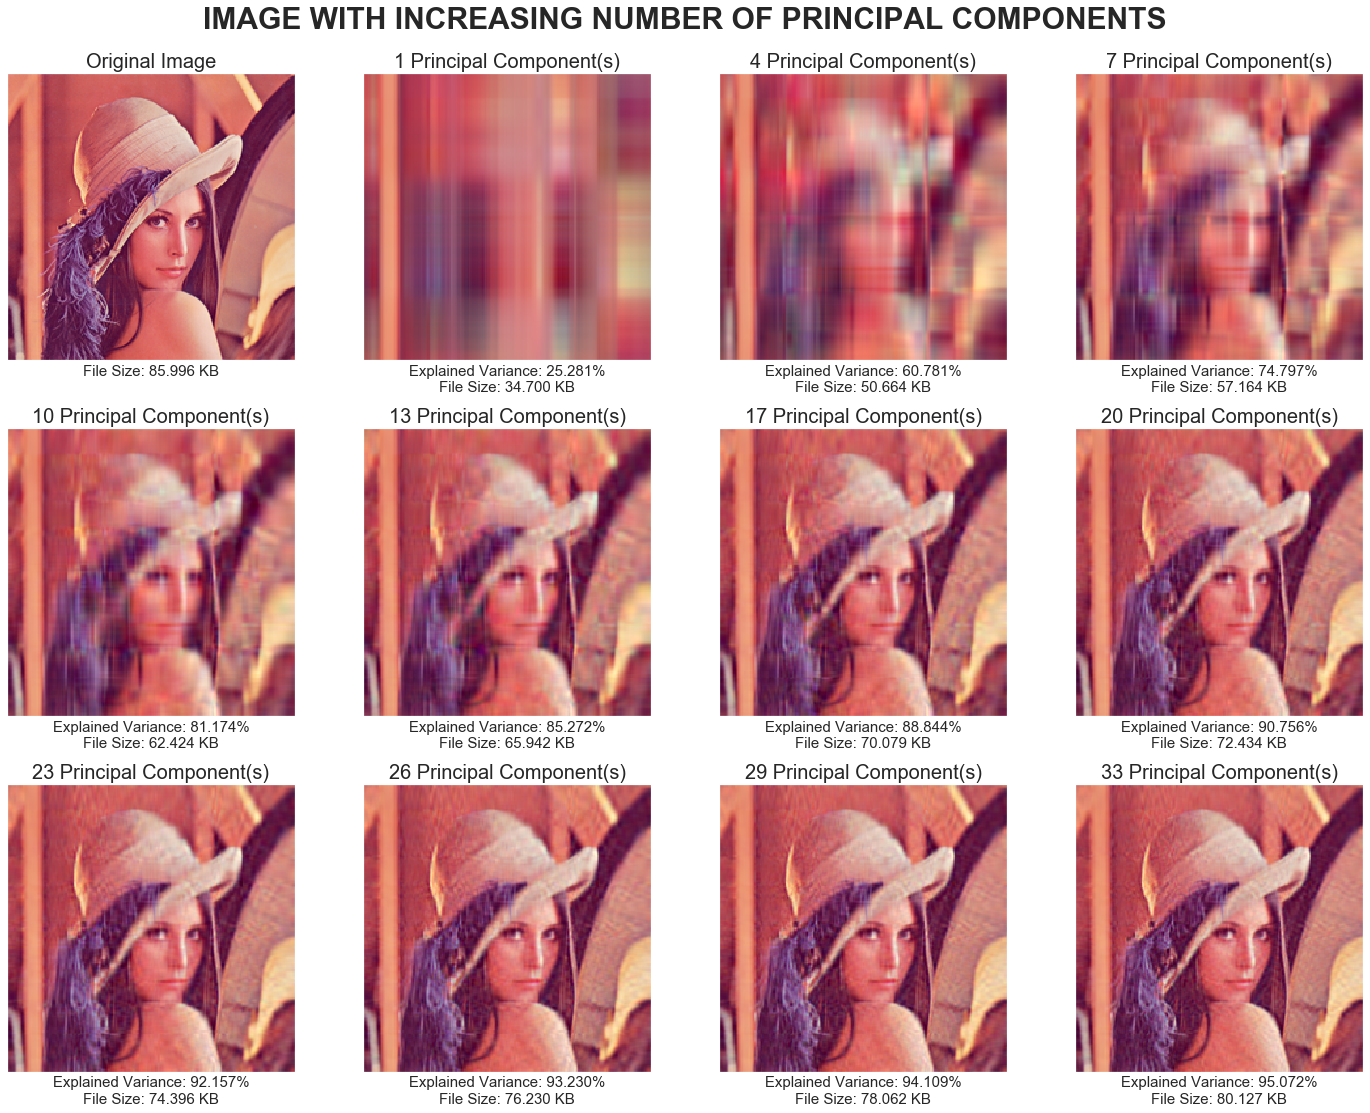

In [30]:
n_pca_images = (3, 4)
end_pc = pca_results[pca_results["Explained Variance"] >= 95].index[0]

fig, axes = plt.subplots(*n_pca_images, figsize=(20,15))
plot_n = np.linspace(1, end_pc, n_pca_images[0]*n_pca_images[1]-1, endpoint = True, dtype = int) 

# PLOTTING ORIGINAL IMAGE
axes[0][0].imshow(X.reshape(*ori_img.size, 3))
axes[0][0].set_title("Original Image", fontsize = 20)
axes[0][0].set_xlabel("File Size: {:.3f} KB".format(ori_img_size), fontsize = 15)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
        
for ax, n in zip(axes.flat[1:], plot_n):
    # PLOTTING COMPRESSED IMAGE
    ax.imshow(pca_results.loc[n, "Pixels"]/255)
    ax.set_title("{} Principal Component(s)".format(n), fontsize = 20)
    ax.set_xlabel("Explained Variance: {:.3f}%\nFile Size: {:.3f} KB".format(pca_results.loc[n, "Explained Variance"],
                                                                            pca_results.loc[n, "Image Size (KB)"]),
                  fontsize = 15)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.suptitle("IMAGE WITH INCREASING NUMBER OF PRINCIPAL COMPONENTS", size = 30, y = 1.03, fontweight = "bold")
plt.show()

## Metric: Search for Optimal No. of PCs

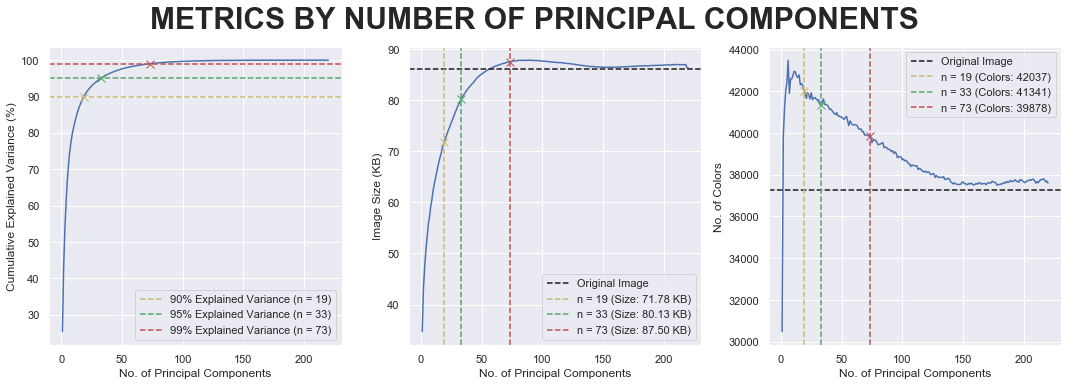

In [31]:
line_colors = "ygr"
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, metric in zip(axes, pca_results.columns[1:]):
    sns.lineplot(x = pca_results.index, y = metric, data = pca_results, ax = ax)
    ax.set_xlabel("No. of Principal Components")
    
    if metric == "Explained Variance":
        lookup_n_var = []
        for idx, exp_var in enumerate([90, 95, 99]):
            lookup_n = pca_results[pca_results[metric] >= exp_var].index[0]
            lookup_n_var.append(lookup_n)
            ax.axhline(y = exp_var, color = line_colors[idx], linestyle = '--',
                       label = "{}% Explained Variance (n = {})".format(exp_var, lookup_n))
            ax.plot(lookup_n, exp_var, color = line_colors[idx], marker = 'x', markersize = 8)
            ax.set_ylabel("Cumulative Explained Variance (%)")
        ax.legend()
        continue
    elif metric == "Image Size (KB)":
        y_val = ori_img_size
        line_label = "n = {} (Size: {:.2f} KB)"
    elif metric == "No. of Colors":
        y_val = ori_img_n_colors
        line_label = "n = {} (Colors: {})"
        
    ax.axhline(y = y_val, color = 'k', linestyle = '--', label = "Original Image")
    for idx, n_components in enumerate(lookup_n_var):
        lookup_value = pca_results.loc[n_components, metric]
        ax.axvline(x = n_components, color = line_colors[idx], linestyle = '--',
                   label = line_label.format(n_components, lookup_value))
        ax.plot(n_components, lookup_value, color = line_colors[idx], marker = 'x', markersize = 8)
    ax.legend()
plt.tight_layout()
fig.suptitle("METRICS BY NUMBER OF PRINCIPAL COMPONENTS", size = 30, y = 1.07, fontweight = "bold")
plt.show()

Want to get optimal number of principal components `n` by analyzing metrics based on explained variance, here are the thought process:
* Left plot: We need 19, 33, and 73 principal components to be able 90%, 95%, and 99% explain the variance of our original image, respectively.
* Mid plot: But there's a trade-off, the more variance we want to explain, the bigger is the image size. The black dashed line indicates the original image size, we want to choose `n` below this line. So, it's either 19 or 33 principal components.
* Right plot: Number of colors present in the image will be less if we increase `n` from 19 to 33 and then to 73. 

From the plots, we can conclude to choose **33 principal components** because it giving us smaller image size with reasonably high explained variance, and number of color similar to the original image.

In [32]:
target_exp_var = 95
n_opt = pca_results[pca_results["Explained Variance"] >= target_exp_var].index[0]
n_opt

33

## Compare to Original Image

In [33]:
pc_reduced = {
    "Type": "PC-Reduced",
    "Pixels": pca_results.loc[n_opt, "Pixels"],
    "No. of Colors": pca_results.loc[n_opt, "No. of Colors"],
    "Image Size (KB)": pca_results.loc[n_opt, "Image Size (KB)"],
    "Relative Variance": pca_results.loc[n_opt, "Explained Variance"]
}
ori_vs_pca = pd.DataFrame([ori, pc_reduced]).set_index("Type")
ori_vs_pca

Pixels  No. of Colors  \
Type                                                                           
Original    [[225, 137, 127], [224, 137, 127], [227, 134, ...          37270   
PC-Reduced  [[[207.8943800542848, 120.1619226529473, 109.2...          41341   

            Image Size (KB)  Relative Variance  
Type                                            
Original          85.996094         100.000000  
PC-Reduced        80.126953          95.072418

In [34]:
relative_size = ori_vs_pca.loc["PC-Reduced", "Image Size (KB)"]/ori_vs_kmeans.loc["Original", "Image Size (KB)"]
print("Size: {:.3f}% of original image size".format(relative_size * 100))

Size: 93.175% of original image size


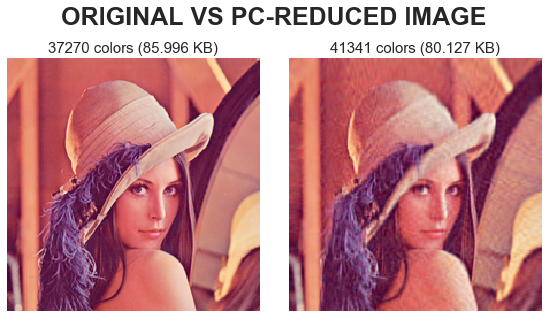

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
for ax, (typ, row) in zip(axes.flat, ori_vs_pca.iterrows()):
    img_array = np.array(row["Pixels"]/255)
    ax.imshow(img_array.reshape(*ori_img.size, 3))
    ax.axis("off")
    ax.set_title("{} colors ({:.3f} KB)".format(row["No. of Colors"], row["Image Size (KB)"]), fontsize=15)
plt.tight_layout()
fig.suptitle("ORIGINAL VS PC-REDUCED IMAGE", size = 25, y = 1.1, fontweight = "bold")
plt.show()

# Comparison

In [36]:
final_compare = pd.DataFrame([ori, color_reduced, pc_reduced]).set_index("Type")
final_compare

Pixels  \
Type                                                               
Original       [[225, 137, 127], [224, 137, 127], [227, 134, ...   
Color-Reduced  [[[232.0675287356287, 146.05028735631967, 119....   
PC-Reduced     [[[207.8943800542848, 120.1619226529473, 109.2...   

               No. of Colors  Image Size (KB)  Relative Variance  
Type                                                              
Original               37270        85.996094         100.000000  
Color-Reduced             12        18.048828          99.969966  
PC-Reduced             41341        80.126953          95.072418

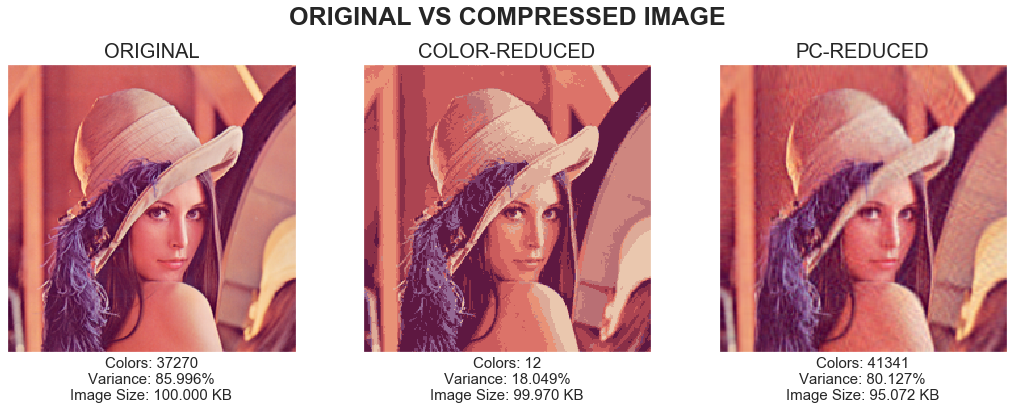

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, (typ, row) in zip(axes.flat, final_compare.iterrows()):
    img_array = np.array(row["Pixels"])/255
    ax.imshow(img_array.reshape(*ori_img.size, 3))
    ax.set_xlabel("Colors: {}\nVariance: {:.3f}%\nImage Size: {:.3f} KB".format(row["No. of Colors"],
                                                                                row["Image Size (KB)"],
                                                                                row["Relative Variance"]), fontsize=15)
    ax.set_title(typ.upper(), fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.suptitle("ORIGINAL VS COMPRESSED IMAGE", size = 25, y = 1.1, fontweight = "bold")
plt.show()

In [38]:
reduction_kmeans = (1-final_compare.loc["Color-Reduced", "Image Size (KB)"] / ori_img_size) * 100
reduction_pca = (1-final_compare.loc["PC-Reduced", "Image Size (KB)"] / ori_img_size) * 100
print("Image Size Reduction using K-Means: {:.3f}%".format(reduction_kmeans))
print("Image Size Reduction using PCA: {:.3f}%".format(reduction_pca))

Image Size Reduction using K-Means: 79.012%
Image Size Reduction using PCA: 6.825%


# Conclusion

We successfully perform image compression using Unsupervised Learning algorithm, such as K-Means Clustering and Dimensionality Reduction using Principal Component Analysis (PCA).

bagian ini nanti ditranslate:

Pada K-Means biasanya penentuan jumlah cluster $k$ dilakukan secara subjektif melalui visualisasi, di notebook ini disajikan metode untuk penentuan secara objektif, yaitu:
- Elbow method using longest distance from the line
- Second derivative using finite difference method

Pada PCA, penentuan banyaknya PC yang digunakan diawali dari target explained variance, kemudian ditinjau lagi dari sisi image size dan jumlah warna untuk mempertimbangkan kesamaannya dengan original image.  

Menggunakan K-Means, size reduction mencapai 79.012% dan mampu menjelaskan 99.97% variance dari original image hanya dengan 12 warna. Menggunakan PCA, size reduction hanya sebesar 6.825% dan menjelaskan 95.072% variance sesuai dengan kemauan kita. Warna yang diperoleh dengan PCA lebih banyak dibandingkan original image menandakan adanya noise pada hasil compressed image. Namun dapat dilihat secara subjektif bahwa warna pada hasil K-Means lebih kasar dibandingkan hasil PCA.

K-Means lebih direkomendasi untuk digunakan dalam mereduksi image size secara signifikan dibandingkan PCA. Namun apabila ingin tetap mempertahankan keseluruhan warna, gunakan PCA.

Saran: boleh dicoba untuk mengombinasikan kedua metode, yaitu PCA kemudian K-Means maupun K-means kemudian PCA.